In [1]:
import pandas as pd
import numpy as np
import anndata
import scanpy as sc
from scipy.sparse import csr_matrix


In [2]:
genes_df = pd.read_csv('/mnt/c/Users/sneha/OneDrive/Desktop/gene expression matrices human/genes-rows.csv')
gene_id_col = genes_df.columns[0] 
print(f"\n Using '{gene_id_col}' as gene identifier")
samples_df = pd.read_csv('/mnt/c/Users/sneha/OneDrive/Desktop/gene expression matrices human/samples-columns.csv')
cell_id_col = samples_df.columns[0]  
print(f"\n Using '{cell_id_col}' as cell identifier")




 Using 'gene' as gene identifier

 Using 'sample_name' as cell identifier


In [3]:

import pandas as pd
from scipy import sparse
import gc  # manually frees up RAM by acting as a garbage collector

def load_sparsematrix(filepath):
    chunksize = 2000  # 2000 rows of the csv at a time
    sparse_chunks = [] # list to temporarily store the sparse matrix chunk
    gene_names = []
    sample_names = None # initialized as none so there's no overwriting of columns with different cells and only gene rows is chunked with all the columns present
    total_rows = 0 # to track how many genes has been processed
    

    reader = pd.read_csv(
        filepath, 
        index_col=0, 
        chunksize=chunksize, 
        engine='c', 
        dtype='float32'
    )

    for i, chunk in enumerate(reader):
      
        if sample_names is None:
            sample_names = chunk.columns.tolist()
            print(f"Detected {len(sample_names):,} cells")

        gene_names.extend(chunk.index.tolist()) # the name of genes are preserved in python list before convversion to sparse
        

        chunk_sparse = sparse.csr_matrix(chunk.values) # the file gets compressed to numeric valuees in form of a sparse matrix
        sparse_chunks.append(chunk_sparse) #using append instead of extend to add one object chunk and not many objects from a list
        
        total_rows += len(chunk)
       
        del chunk
    
    print(f"\n Stacking sparse chunks")
    full_sparsematrix = sparse.vstack(sparse_chunks)
    

    del sparse_chunks
    gc.collect()
    
    print(" Loaded successfully!")
    print(f"    Shape: {full_sparsematrix.shape}")
    
    # real memory size
    mem = (full_sparsematrix.data.nbytes + full_sparsematrix.indptr.nbytes + full_sparsematrix.indices.nbytes) / 1e9
    print(f"   RAM Used: {mem:.2f} GB")
    
    return full_sparsematrix, gene_names, sample_names

path = '/mnt/c/Users/sneha/OneDrive/Desktop/gene expression matrices human/exon-matrix.csv'

raw_sparsematrix, genes, cells = load_sparsematrix(path)

Detected 15,928 cells

 Stacking sparse chunks
 Loaded successfully!
    Shape: (50281, 15928)
   RAM Used: 0.70 GB


In [4]:

import anndata as ad
print(f"Matrix shape:{raw_sparsematrix.shape}")
print(f"Genes list: {len(genes)}")
print(f"Cells list: {len(cells)}")
# anndata object, it except cell x genes so we transpose it
adata = ad.AnnData(
    X=raw_sparsematrix.T,
    obs=pd.DataFrame(index=cells),
    var=pd.DataFrame(index=genes)
)

print("AnnData object created successfully!")
print(adata.X)
# print(adata.X[:5, :5].toarray())

Matrix shape:(50281, 15928)
Genes list: 50281
Cells list: 15928


/usr/lib/python3.12/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/mnt/c/Users/sneha/BrainCellAtlas/venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object created successfully!
<Compressed Sparse Column sparse matrix of dtype 'float32'
	with 87701834 stored elements and shape (15928, 50281)>
  Coords	Values
  (66, 0)	30.0
  (732, 0)	32.0
  (1772, 0)	33.0
  (7374, 0)	2.0
  (8734, 0)	31.0
  (14473, 0)	9.0
  (15809, 0)	3.0
  (1263, 1)	53.0
  (1742, 1)	11.0
  (1876, 1)	2.0
  (1969, 1)	2.0
  (2287, 1)	114.0
  (3263, 1)	18.0
  (6388, 1)	126.0
  (6786, 1)	22.0
  (6970, 1)	266.0
  (8831, 1)	32.0
  (8916, 1)	1.0
  (10992, 1)	16.0
  (11873, 1)	1.0
  (12447, 1)	21.0
  (12495, 1)	14.0
  (13151, 1)	1.0
  (13952, 1)	1.0
  (14013, 1)	69.0
  :	:
  (15812, 50280)	2.0
  (15816, 50280)	1.0
  (15824, 50280)	1.0
  (15826, 50280)	1.0
  (15842, 50280)	2.0
  (15843, 50280)	1.0
  (15845, 50280)	1.0
  (15848, 50280)	2.0
  (15855, 50280)	2.0
  (15858, 50280)	2.0
  (15861, 50280)	1.0
  (15865, 50280)	1.0
  (15870, 50280)	2.0
  (15874, 50280)	1.0
  (15875, 50280)	1.0
  (15879, 50280)	1.0
  (15881, 50280)	1.0
  (15891, 50280)	1.0
  (15893, 50280)	1.0
 

In [5]:
# Cell 6: Calculate Basic QC Metrics

import numpy as np

# Total counts per cell
adata.obs['n_counts'] = np.array(adata.X.sum(axis=1)).flatten()

# Number of genes detected per cell (genes with count > 0)
adata.obs['n_genes'] = np.array((adata.X > 0).sum(axis=1)).flatten()

# Total counts per gene
adata.var['n_counts'] = np.array(adata.X.sum(axis=0)).flatten()

# Number of cells expressing each gene
adata.var['n_cells'] = np.array((adata.X > 0).sum(axis=0)).flatten()


print(f"\n Cell-level metrics:")
print(f"   Mean counts per cell: {adata.obs['n_counts'].mean():.2f}")
print(f"   Median counts per cell: {adata.obs['n_counts'].median():.2f}")
print(f"   Mean genes per cell: {adata.obs['n_genes'].mean():.2f}")
print(f"   Median genes per cell: {adata.obs['n_genes'].median():.2f}")


 Cell-level metrics:
   Mean counts per cell: 760614.62
   Median counts per cell: 749374.00
   Mean genes per cell: 5506.14
   Median genes per cell: 5465.00


In [6]:
# Cell 7: Save and Verify

import os
import scanpy as sc

output_path = '/mnt/c/Users/sneha/BrainCellAtlas/data/processed/human_mtg_brain_atlas.h5ad'
os.makedirs(os.path.dirname(output_path), exist_ok=True)
adata.var_names_make_unique()
print("Fixed non-unique variable names.")
print(f"Saving to {output_path}")
adata.write_h5ad(output_path)

file_size = os.path.getsize(output_path) / 1e9
print(f"Saved successfully! Size: {file_size:.2f} GB")

# Verify read-back
print("\n verifying file integrity...")
adata_test = sc.read_h5ad(output_path)
print(f" File verified! Shape: {adata_test.shape}")

Fixed non-unique variable names.
Saving to /mnt/c/Users/sneha/BrainCellAtlas/data/processed/human_mtg_brain_atlas.h5ad
Saved successfully! Size: 0.71 GB

 verifying file integrity...
 File verified! Shape: (15928, 50281)


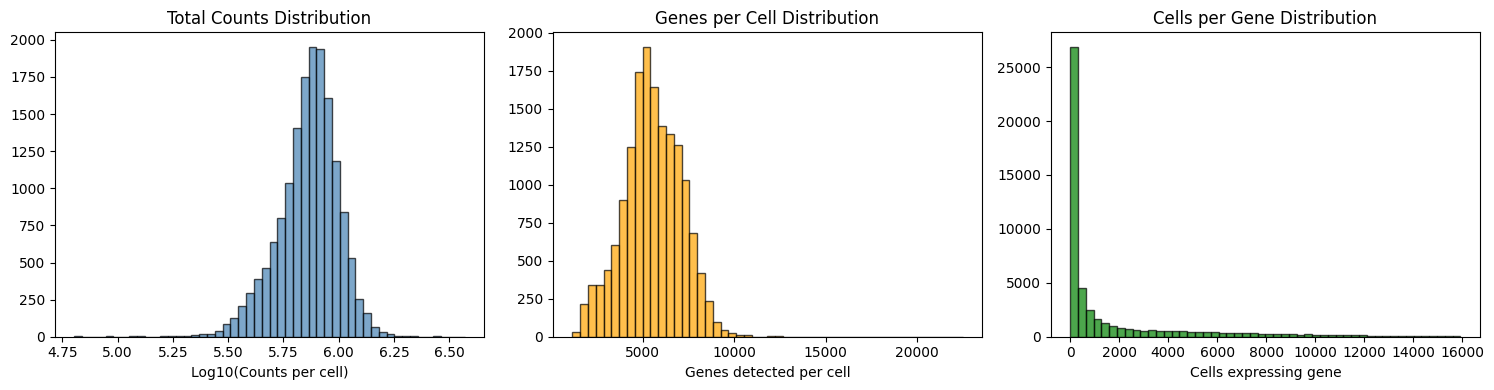

in the above plot we can see the distribution of counts per cell peaking at around 5.8 which is approximately 630000 counts per cell of RNA molecules detected in the genes. this is a good indicator of data quality as it shows that the sequencing depth was sufficient to capture a wide range of gene expression levels across the cells.
in the second plot we can see that most cells have around 2000 to 4000 genes detected which is typical for high-quality single-cell RNA-seq data. this indicates that the cells are transcriptionally active and that the sequencing depth was adequate to capture a diverse set of expressed genes. less than 500 genes per cell may indicate low-quality or dying cells, while very high gene counts could suggest doublets or multiplets.
the third plot shows the distribution of how many cells express each gene. most genes are expressed in a small number of cells, which is typical for single-cell data where many genes are cell-type specific or lowly expressed. a few gene

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np

# Create directory (Windows path - make sure it exists)
os.makedirs('/mnt/c/Users/sneha/BrainCellAtlas/results/figures', exist_ok=True)

# Create figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Total counts distribution of RNA molecules per cell 
axes[0].hist(np.log10(adata.obs['n_counts'] + 1), bins=50, 
             edgecolor='black', color='steelblue', alpha=0.7)
axes[0].set_xlabel('Log10(Counts per cell)')
axes[0].set_title('Total Counts Distribution')

# Genes per cell distribution
axes[1].hist(adata.obs['n_genes'], bins=50, 
             edgecolor='black', color='orange', alpha=0.7)
axes[1].set_xlabel('Genes detected per cell')
axes[1].set_title('Genes per Cell Distribution')

# Cells per gene distribution
axes[2].hist(adata.var['n_cells'], bins=50, 
             edgecolor='black', color='green', alpha=0.7)
axes[2].set_xlabel('Cells expressing gene')
axes[2].set_title('Cells per Gene Distribution')

plt.tight_layout()
plt.show()


1 - The above plot we can see the distribution of counts per cell peaking at around 5.8 which is approximately 630000 counts per cell of RNA molecules detected in the genes. this is a good indicator of data quality as it shows that the sequencing depth was sufficient to capture a wide range of gene expression levels across the cells.


2 - The second plot we can see that most cells have around 2000 to 4000 genes detected which is typical for high-quality single-cell RNA-seq data. this indicates that the cells are transcriptionally active and that the sequencing depth was adequate to capture a diverse set of expressed genes. less than 500 genes per cell may indicate low-quality or dying cells, while very high gene counts could suggest doublets or multiplets.

3 - The third plot shows the distribution of how many cells express each gene. most genes are expressed in a small number of cells, which is typical for single-cell data where many genes are cell-type specific or lowly expressed. a few genes are expressed in a large number of cells, likely representing housekeeping genes like GAPDH or ACTB that are found in almost every cell to keep it alive, essential for basic cellular functions.